# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape

(45993, 3)

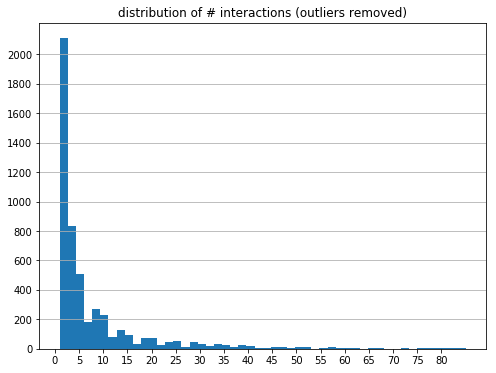

In [4]:
user_interaction_counts = df.groupby('email').count()['title']
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(user_interaction_counts, bins=50, range=(1,85))
ax.set_xticks(np.arange(0,85,5))
ax.set_yticks(np.arange(0,2200, 200))
ax.set_title('distribution of # interactions (outliers removed)')
ax.grid(which='major', axis='y')
plt.show();

In [5]:
user_interaction_counts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

In [6]:
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =  364# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
#duplicate articles
for col in df_content.columns:
    print('{} duplicates: {}'.format(col, df_content.duplicated(col).sum()))

doc_body duplicates: 19
doc_description duplicates: 33
doc_full_name duplicates: 5
doc_status duplicates: 1055
article_id duplicates: 5


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

In [9]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
df.article_id.unique().shape

(714,)

In [11]:
df.email.dropna().unique().shape

(5148,)

In [12]:
df.shape

(45993, 3)

In [13]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051# The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
df.article_id.value_counts().sort_values(ascending=False).head(5)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [15]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ids = df.article_id.value_counts().sort_values(ascending=False).head(n).index
    top_articles = df.loc[~df.article_id.duplicated() & df.article_id.isin(ids)].title.values

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles (str)- (list) A list of the top 'n' article ids
    
    '''
    top_articles = list(map(str, df.article_id.value_counts().sort_values(ascending=False).head(n).index))
    return top_articles # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings' 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    mapping = {True:1, False:0}
    
    user_item_df = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item_df = ~user_item_df.isnull() #True is not empty, false is empty
    user_item = user_item_df.applymap(lambda x: mapping[x])
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

options:
- kendall tau (distance based similarity measure)
- dot product of each user to get similarity

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    # remove the own user's id
    similarity.drop(user_id, inplace=True)
    # create list of just the ids
    most_similar_users = list(similarity.index)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
np.where(user_item.loc[1]==1)

(array([ 22,  54,  76, 123, 138, 147, 152, 178, 222, 235, 253, 267, 285,
        315, 329, 374, 401, 408, 438, 526, 538, 540, 566, 600, 609, 651,
        656, 665, 672, 678, 697, 699, 700, 701, 706, 708]),)

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    #first filter only the associated article_ids
    #, then get only the first occurence of each article_id, title and make lists into title.
    #is sorted in same order as article_ids
    article_names = list(df[df.article_id.isin(article_ids)].groupby('article_id')['title'].first())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #find the places in which the user_item mtx ==1 for that user
    #look up the columns to get actual article_id
    user_id = int(float(user_id))
    article_ids = list(user_item.columns[np.where(user_item.loc[user_id]==1)])
    #get article name from article id
    article_names = get_article_names(article_ids)
    return [str(a_id) for a_id in article_ids], article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    recs = []
    seen_ids, _ = get_user_articles(user_id)
    print(seen_ids)
    #iterate thru users
    for user in similar_users:
        ids, names = get_user_articles(user)
        
        #find ids that have not been read by user yet
        not_seen = list(set(ids) - (set(seen_ids) & set(ids)))
        
        #add to recs
        recs.extend(not_seen)
        if(len(recs)>=m): break #when we have found enough articles
        
    return recs[:m] # return your recommendations for this user_id    

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['43.0', '109.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0', '494.0', '525.0', '585.0', '626.0', '668.0', '732.0', '768.0', '910.0', '968.0', '981.0', '1052.0', '1170.0', '1183.0', '1185.0', '1232.0', '1293.0', '1305.0', '1363.0', '1368.0', '1391.0', '1400.0', '1406.0', '1427.0', '1429.0', '1430.0', '1431.0', '1436.0', '1439.0']


['simple graphing with ipython and\xa0pandas',
 'modeling energy usage in new york city',
 'using deep learning with keras to predict customer churn',
 'pixiedust gets its first community-driven feature in 1.0.4',
 'the power of machine learning in spark',
 'variational auto-encoder for "frey faces" using keras',
 'machine learning for the enterprise',
 'machine learning and the science of choosing',
 'deep learning from scratch i: computational graphs',
 'analyze accident reports on amazon emr spark']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #find user similarity w/ dot product
    similarity = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    similarity = similarity.sort_values(ascending=False).drop(user_id).to_frame(name='similarity').reset_index()

    #get number of interactions for each user
    num_interactions = df.user_id.value_counts().to_frame('num_interactions')
    
    #combine the value counts with similarity
    neighbors_df = similarity.merge(num_interactions, left_on='user_id', 
                        right_index=True).rename(columns={'user_id':'neighbor_id'})

    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    try:
        #get already read articles
        user_article_ids, _ = get_user_articles(user_id)
    except KeyError: #user does not exist
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)
    #get neighbors sorted by similarity (descending)
    neighbours = get_top_sorted_users(user_id).neighbor_id.values
    
    #get top 400 articles (their ids), if outside of top 400 we dont want to recommend
    all_articles_sorted = get_top_article_ids(300)
    
    recs = []
    
    for user in neighbours:
        neighbour_article_ids, _ = get_user_articles(user)
        not_seen = list(set(neighbour_article_ids)-(set(user_article_ids)&set(neighbour_article_ids)))
        
        #sort by highest ranked articles, add to list
        not_seen_sorted = list(set(all_articles_sorted) &set(not_seen))
        
        recs.extend(not_seen)
        if(len(recs)>=m):
            recs = recs[:m]
            break; #do not add any more
    
    return recs, get_article_names(recs)

In [30]:
get_top_sorted_users(1).head(5)

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [31]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1160.0', '1368.0', '761.0', '1151.0', '1330.0', '109.0', '142.0', '1396.0', '939.0', '1386.0']

The top 10 recommendations for user 20 are the following article names:
['tensorflow quick tips', 'neural networks for beginners: popular types and applications', 'variational auto-encoder for "frey faces" using keras', 'deep learning from scratch i: computational graphs', 'airbnb data for analytics: venice listings', 'analyze accident reports on amazon emr spark', 'insights from new york car accident reports', 'putting a human face on machine learning', 'small steps to tensorflow', 'times world university ranking analysis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [32]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

We would not be able to use any recommendation that relies on user similarity. Since the new user has most likely not read any articles yet, we cannot generate a similarity metric, and if a user has only read one article that is also not necessarily the best to determine user similarity based on only one article.

We could however instead recommend based solely on a random subset of the best ranked (most interacted with) articles. This also makes a lot of sense for new users since they will likely want to explore the platform, and would probably like to start with some of the more popular articles. The downside of this is that it could potentially skew our recommendation alogithm later on as it would see users who have interacted with all the same articles and think they are similar, but this would only be because they were suggested the same articles to begin with. Also basing article popularity on number of interactions presents the challenge that articles that are recommended in the new user scenario are likely to get more hits, wich would further increase their chances of being show to the next new user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [34]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs, new_user_recs_names = user_user_recs_part2('0.0', 10)


In [35]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [36]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')
nltk.download('webtext')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import nps_chat


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [37]:
def tokenize(x):
    stop_words = (set(stopwords.words('english')) | set(nltk.corpus.webtext.words()) | set(nltk.corpus.abc.words()))
    tokens = word_tokenize(x) #split each message into individual words
    lemmatizer = WordNetLemmatizer()
    clean_tokens=[]
    for token in tokens:
        #clean each token from whitespace and punctuation, and conver to
        #root of word ie walking->walk
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    filtered = [word for word in clean_tokens if word not in stop_words and word.isalpha()]
    return filtered

In [38]:
def make_content_recs(data_id, user_id=True, m=10, df=df):
    '''
    INPUT:
        data_id (str) - id of either user or article
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
    OUTPUT:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended
        
    Description:
       This content based recommender looks at the articles the user has interacted with.
       It goes through each article and using he NLTK library, finds the most common words
       (related to content) throughout all the articles.
       
       Based on these most common words, the recommender looks at the sums of words in
       the content of each article, and based on the number of matches as well as the
       general popularity of the article it gives back the best recommendations.
    '''
    if(user_id):
        user_id = data_id
        try:
            #get already read articles
            article_ids, _ = get_user_articles(user_id)
        except KeyError: #user does not exist
            print('User Doesnt Exist, Recommending Top Articles')
            recs = get_top_article_ids(m)
            return recs, get_article_names(recs)
    
    else:
        article_ids = data_id
        
    content = df_content[df_content['article_id'].isin(list(map(float, article_ids)))]
    print(content)
    words=[]
    for col in ['doc_full_name', 'doc_description', 'doc_body']:
        tokenized = tokenize(content[col].str.cat(sep=' '))
        words.extend(tokenized)
        
    common_words = pd.value_counts(words).sort_values(ascending=False)[:5].index

    counts = []
    for word in common_words:
        counts.append((df_content.doc_body.str.count(word).fillna(0)+ \
                            df_content.doc_full_name.str.count(word).fillna(0)+ \
                            df_content.doc_body.str.count(word).fillna(0)))
        
    top_matches = pd.DataFrame({'top_matches':pd.concat(counts)})
    
    top_matches['article_id'] = df_content.article_id.astype(float)
    article_occurences = pd.DataFrame({'occurences':df.article_id.value_counts()})

    top_matches = top_matches.merge(article_occurences, left_on='article_id', right_index=True)
    top_matches.sort_values(['top_matches', 'occurences'], ascending=False, inplace=True)    

    recs = top_matches.article_id[:m].values.astype(str)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?


#### Content Based Recommender

This content based recommender looks at the articles the user has interacted with.
It goes through each article and using he NLTK library, finds the most common words
(related to content) throughout all the articles.

Based on these most common words, the recommender looks at the sums of words in
the content of each article, and based on the number of matches as well as the
general popularity of the article it gives back the best recommendations.

If the user has not read any articles yet, then we can't really give any content based recommendations, and just return back some of the most popular articles.

There is a lot of potential improvement and optimization for this recommender. For example one could construct a custom NLTK corpus which would filter out article words. Currently I use a combination of a couple standard NLTK corpora.

Furthermore, instead of summing the total occurences of the top words in each article, it could be better do distinguish how many times that word pops up in the title, description, and body to better refine the results.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


In [39]:
# make recommendations for a brand new user
make_content_recs('0.0', user_id=True)

User Doesnt Exist, Recommending Top Articles


(['1429.0',
  '1330.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0'],
 ['analyze energy consumption in buildings',
  'apache spark lab, part 1: basic concepts',
  'finding optimal locations of new store using decision optimization',
  'gosales transactions for logistic regression model',
  'healthcare python streaming application demo',
  'insights from new york car accident reports',
  'predicting churn with the spss random tree algorithm',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'use deep learning for image classification',
  'visualize car data with brunel'])

In [40]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(['1427.0'], user_id=False)

Empty DataFrame
Columns: [doc_body, doc_description, doc_full_name, doc_status, article_id]
Index: []


ValueError: No objects to concatenate

# HOW DO I CONVERT THE ARTICLE IDS FOR LOOKUP IN DF_CONTENT?
it doesnt seem to match. the article ids in df_content are in range [0,1050] whereas in df the article ids are >1440

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [41]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [42]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [43]:
# Perform SVD on the User-Item Matrix 
u, s, vt = np.linalg.svd(user_item_matrix)

Our situation is different than the one in the lesson since this matrix does not have any missing values. SVD only works if this condition is satisfied. However, in this situation we do not need to do any filling of values either since a `1` denotes interaction and `0` denotes no interaction with the item.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [110]:
def latent_feat_optimization(num_latent_feats, user_item_mtx, u, s, vt):
    '''
    Calculate the predictions for the user/item matrix based on the number of features 
    that are kept in the SVD decomposition of the original matrix.
    
    The more features are kept the higher the accuracy since less information is lost/dropped.
    
    NB---------
    n: number of users
    k: number of latent features
    i: number of items
    
    SVD Makes predictions for ratings of a specific item by 
    taking the dot product of a row from u, the s matrix, and a certain column from V_t 
    
    Inputs
        num_latent_feats (array) - latent features to iterate through and check acc.
        user_item_mtx - original dataset to compare results to
        u - U matrix from SVD (shape: nxk)
        s - sigma matrix from SVD (shape: kxk)
        vt - V_transpose matrix from SVD (shape: kxi)
    '''
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        u_new = u[:, :k]
        s_new = np.diag(s[:k])
        vt_new = vt[:k, :]
        # take dot product to get estimates
        est_mtx = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_mtx, est_mtx)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
        
    return sum_errs

In [90]:
def plot_latent_feat_acc(sum_errs, num_users, num_latent_feats):
    '''
    Graph the accuracy of predictions vs # latent features kept in SVD of matrix
    
    Inputs
        sum_errs (array) - errors at each iteration of latent feature testing
        num_items (int) - number of items in relevant matrix (used to calculate accuracy)
        num_latent_features (array) - array of latent features used to test accuracy
    '''
    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/num_users);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    plt.show();

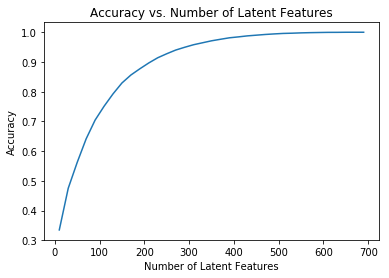

In [67]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = latent_feat_optimization(num_latent_feats, user_item_matrix, u, s, vt)
plot_latent_feat_acc(sum_errs, df.shape[0], num_latent_feats)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [46]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [47]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
print(user_item_train.shape,
      user_item_test.shape)

(4487, 714) (682, 574)


In [49]:
train_idx = user_item_train.index

In [50]:
user_overlap = set(train_idx)&set(test_idx) #users in both train and test set
print(user_overlap, len(user_overlap))

{3968, 3777, 4002, 3684, 4293, 2917, 4487, 4231, 3527, 4204, 3532, 3024, 4274, 3801, 3093, 3989, 3990, 3193, 3740, 3998} 20


In [51]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


##### My thoughts on the results above:
- If we train on the first matrix, we will only be able to make a prediction of which movie a user should watch for the 20 users that we have already seen, and not any other user (based on training set) (there after we could 'check' predictions from testing set by comparing to the predictions of the testing set. Therefore, we can't make predictions for 662 of the 682 users in the testing set.

- since all 574 movies of the test set are a subset of movies in training set we can make predictions for all/recommendations based on 574 movies in the testing set.

`5.` Now use the **user_item_train** dataset from above to find U , S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [69]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [70]:
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [71]:
overlap_idx = np.subtract(list(user_overlap), 1) #index of overlapping users in main df

In [85]:
item_overlap_idx = [user_item_train.columns.get_loc(col) for col in test_arts]

In [102]:
u_overlap = u_train[overlap_idx, :]
s_overlap = s_train
vt_overlap = vt_train[:, item_overlap_idx]

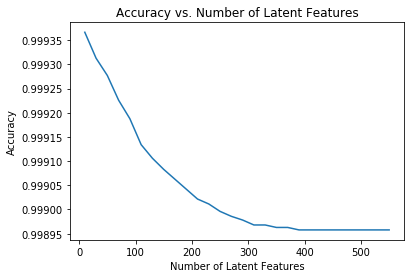

In [115]:
# how well you can use the training decomposition to predict on test data
num_latent_feats = np.arange(10,560,20)
num_preds = user_item_test.shape[0] * user_item_test.shape[1]
sum_errs = latent_feat_optimization(num_latent_feats, user_item_test.loc[user_overlap], u_overlap, s_overlap, vt_overlap)
plot_latent_feat_acc(sum_errs, num_preds, num_latent_feats)

### Comments on Results of SVD Trials
I was surprised to see that the accuracy (learning) curve was the inverse of the one I saw during training. The simple explanatino for this is that with increasing latent features causes overfitting during training. This means that even though our model performs better on the training set it does not generalize well to out of sample predictions. Based on this I would try to keep fewer latent features. 

I would not yet implement a recommendation system solely using SVD as the training and testing sample is still quite small. Since we only have overlap of a few users and some movies between training and testing, I cannot detrmine with high certainty that the SVD recommendations work well in this case.

Nevertheless, this approach showed the benefits and possibility of training and testing sets even with recommendation systems. The same training and testing methodology could apply across the other recommendation methods (collaborative filtering, content based etc)

In [126]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0